In [2]:
import pyccl as ccl
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

In [3]:
# Cl from linear galaxy-bias model, compared with Gabriela's output

In [4]:
#Get Cls to compute correlation
#Redshift distribution
zmean1=1.0; zmean2=1.5;
sigz1=0.15; sigz2=0.15;
nzs=512;

In [5]:
#Analytic redshift distributions
z_a_1=np.linspace(zmean1-5*sigz1,zmean1+5*sigz1,nzs);
z_a_2=np.linspace(zmean2-5*sigz2,zmean2+5*sigz2,nzs);
pz_a_1=np.exp(-0.5*((z_a_1-zmean1)/sigz1)**2)
pz_a_2=np.exp(-0.5*((z_a_2-zmean2)/sigz2)**2)

#Bias parameters for these distributions
bz_a_1=np.ones_like(z_a_1); bz_a_2=np.ones_like(z_a_2);

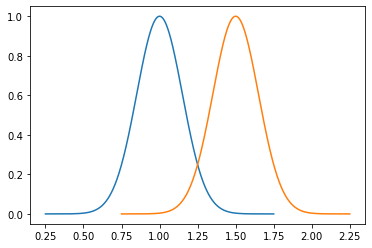

In [6]:
plt.plot(z_a_1, pz_a_1)
plt.plot(z_a_2, pz_a_2)

In [7]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.8, n_s=0.96, transfer_function='bbks', matter_power_spectrum='linear')

In [8]:
z = np.linspace(0., 1., 200)
n = np.exp(-((z-0.5)/0.1)**2)
b = np.sqrt(1.+z)
ell = np.arange(2,10)

In [9]:
lens = ccl.WeakLensingTracer(cosmo, (z,n))
nc = ccl.NumberCountsTracer(cosmo, False, dndz=(z,n), bias=(z,b))
cmbl = ccl.CMBLensingTracer(cosmo, 1100.)

In [10]:
corr_lens_nc = ccl.angular_cl(cosmo, lens, nc, ell)
corr_nc_nc = ccl.angular_cl(cosmo, nc, nc, ell)

In [11]:
import pyccl.nl_pt as pt
import pyccl.ccllib as lib

In [12]:
# growth factor
gz = ccl.growth_factor(cosmo, 1./(1+z))
# Biases for number counts 
b_1 = 2.0 # constant values for now
b_2 = 1.0
b_s = 1.0

# Biases for IAs. Will be converted to the input c_IA values below.
a_1 = 1.
a_2 = 0.5
a_d = 0.5

In [13]:
# Define a redshift range and associated growth factor:
z = np.linspace(0,1,128)
gz = ccl.growth_factor(cosmo, 1./(1+z))

# Let's convert the a_IA values into the correctly normalized c_IA values:
Om_m = cosmo['Omega_m']
rho_crit = lib.cvar.constants.RHO_CRITICAL
rho_m = lib.cvar.constants.RHO_CRITICAL * cosmo['Omega_m']
Om_m_fid = 0.3  # or could use DES convention and just remove Om_m/Om_m_fid

c_1_t = -1*a_1*5e-14*rho_crit*cosmo['Omega_m']/gz
c_d_t = -1*a_d*5e-14*rho_crit*cosmo['Omega_m']/gz
c_2_t = a_2*5*5e-14*rho_crit*cosmo['Omega_m']**2/(Om_m_fid*gz**2)  # Blazek2019 convention
c_2_t = a_2*5*5e-14*rho_crit*cosmo['Omega_m']/(gz**2)  # DES convention

# Or we just use the built-in function for IA normalization
c_1,c_d,c_2 = pt.translate_IA_norm(cosmo, z, a1=a_1, a1delta=a_d, a2=a_2,
                                   Om_m2_for_c2 = False)

In [14]:
# Number counts
ptt_g = pt.PTNumberCountsTracer(b1=b_1, b2=b_2, bs=b_s)

# Intrinsic alignments
ptt_i = pt.PTIntrinsicAlignmentTracer(c1=(z,c_1), c2=(z,c_2), cdelta=(z,c_d))
ptt_i_nla = pt.PTIntrinsicAlignmentTracer(c1=(z,c_1)) # to compare using the standard WLTracer

# Matter
ptt_m = pt.PTMatterTracer()

# Note that we've assumed constant biases for simplicity, but you can also make them z-dependent:
bz = b_1 / gz
ptt_g_b = pt.PTNumberCountsTracer(b1=(z, bz))

In [15]:
# The `with_NC` and `with_IA` flags will tell FastPT to initialize the right things.
# `log10k_min/max and nk_per_decade will define the sampling in k you should use.
ptc = pt.PTCalculator(with_NC=True, with_IA=True,
                      log10k_min=-4, log10k_max=2, nk_per_decade=20)

In [16]:
# Galaxies x galaxies.
# If `tracer2` is missing, an auto-correlation for the first tracer is assumed.
pk_gg = pt.get_pt_pk2d(cosmo, ptt_g, ptc=ptc)

# Galaxies x matter
pk_gm = pt.get_pt_pk2d(cosmo, ptt_g, tracer2=ptt_m, ptc=ptc)

# Galaxies x IAs
pk_gi = pt.get_pt_pk2d(cosmo, ptt_g, tracer2=ptt_i, ptc=ptc)

# IAs x IAs
pk_ii, pk_ii_bb = pt.get_pt_pk2d(cosmo, ptt_i, tracer2=ptt_i, ptc=ptc, return_ia_ee_and_bb=True)
pk_ii_nla = pt.get_pt_pk2d(cosmo, ptt_i_nla, tracer2=ptt_i_nla, ptc=ptc,)

# IAs x matter
pk_im = pt.get_pt_pk2d(cosmo, ptt_i, tracer2=ptt_m, ptc=ptc)

# Matter x matter
pk_mm = pt.get_pt_pk2d(cosmo, ptt_m, tracer2=ptt_m, ptc=ptc)

In [23]:
nz = np.exp(-((z-0.7)/0.1)**2)
# Number counts
# We give this one a bias of 1, since we've taken care of galaxy bias at the P(k) level.
t_g = ccl.NumberCountsTracer(cosmo, True, dndz=(z, nz), bias=(z, np.ones_like(z)))